In [5]:
import pandas as pd
import os
import glob

import seaborn as sns
from matplotlib import pyplot as plt

In [6]:
df = pd.DataFrame()
for i, d in enumerate(os.listdir('data')):
    if '.csv' in d: os.rename('data/'+d, f'data/DataExtact-{i}')

for p in glob.glob('data/**/*.csv'):
    df = pd.concat([df, pd.read_csv(p)])

df = df.drop_duplicates()

print(len(df))

1543541


In [7]:
import numpy as np
print(np.sum(df.duplicated()))

0


In [8]:
from countryinfo import CountryInfo

def getArea(country_name):
    return CountryInfo(country_name).info()['area']

def getPop(country_name):
    return CountryInfo(country_name).info()['population']

country_df = pd.DataFrame()
country_df['Country'] = df['Country'].unique()
country_df['Area'] = country_df['Country'].apply(getArea)
country_df['Population'] = country_df['Country'].apply(getPop)

df.to_csv('final_data.csv')
country_df.to_csv('country_data.csv')

# Q.3 Do the regulations introduced by the European Commission change anything compared to other countries?
## First, let's analyze potential trends in the air quality data over the years for each country individually. Let's see if this got sort of "flattened" after the regulations have been added.
We limit ourselves to the following pollutants:

In [9]:
pollutants = ['CO', 'SO2']
poll_df = df.loc[df['Air Pollutant'].isin(pollutants)]

Let's check what the data looks like

In [10]:
poll_df.head(5)

,Country,Air Quality Network,Air Quality Network Name,Air Quality Station EoI Code,Air Quality Station Name,Sampling Point Id,Air Pollutant,Air Pollutant Description,Data Aggregation Process Id,Data Aggregation Process,...,Air Quality Station Area,Longitude,Latitude,Altitude,City,City Code,City Population,Source Of Data Flow,Calculation Time,Link to raw data (only E1a/validated data from AQ e-Reporting)
0,Netherlands,NET-NL010A,Landelijk Meetnet Luchtkwaliteit,NL00133,Wijnandsrade-Opfergeltstraat,SPO-NL00133_00001_101,SO2,Sulphur dioxide (air),P1Y-day-per50,1 year 50 %ile of daily values in a year,...,suburban,5.8818,50.9023,96.0,NaN,NaN,NaN,Reporting within EoI/AirBase 8,31/12/2012 00:00:00,NaN
1,Netherlands,NET-NL010A,Landelijk Meetnet Luchtkwaliteit,NL00133,Wijnandsrade-Opfergeltstraat,SPO-NL00133_00001_101,SO2,Sulphur dioxide (air),P1Y-hr-per50,1 year 50 percentile,...,suburban,5.8818,50.9023,96.0,NaN,NaN,NaN,Reporting within EoI/AirBase 8,31/12/2012 00:00:00,NaN
12,Netherlands,NET-NL010A,Landelijk Meetnet Luchtkwaliteit,NL00230,Biest Houtakker-Biestsestraat,SPO-NL00230_00001_101,SO2,Sulphur dioxide (air),P1Y-day-per50,1 year 50 %ile of daily values in a year,...,rural,5.1485,51.5184,15.0,NaN,NaN,NaN,Reporting within EoI/AirBase 8,31/12/2012 00:00:00,NaN
14,Netherlands,NET-NL010A,Landelijk Meetnet Luchtkwaliteit,NL00237,Eindhoven-Noordbrabantlaan,SPO-NL00237_00001_101,SO2,Sulphur dioxide (air),P1Y-hr-max-per99.73,1 year 99.73 %ile of hourly values in a given ...,...,urban,5.4448,51.4442,18.0,Greater Eindhoven ...,NL005C2 ...,276979.0,Reporting within EoI/AirBase 8,31/12/2012 00:00:00,NaN
17,Netherlands,NET-NL010A,Landelijk Meetnet Luchtkwaliteit,NL00234,Putte-Larikslaan,SPO-NL00234_00001_101,SO2,Sulphur dioxide (air),P1Y-hr-max,1 year hour max,...,rural,4.3883,51.3664,16.0,NaN,NaN,NaN,Reporting within EoI/AirBase 8,31/12/2012 00:00:00,NaN


Notice that the same information about pollution is collected from different places in a single country. Those might lead to different observations. Further, the data is collected in different ways within the same location. Let's have a look at what we should care about.

In [11]:
poll_df['Data Aggregation Process'].unique()

array(['1 year 50 %ile of daily values in a year', '1 year 50 percentile',
       '1 year 99.73 %ile of hourly values in a given year',
       '1 year hour max', '1 year day exceed 125', '1 year day max',
       'Annual mean / 1 calendar year', '1 year day max 4',
       '1 year 99.18 percentile of daily maximum',
       '1 year daymax average', '1 year hour max 25',
       '1 year hour exceed 350', '1 year day max max',
       '1 year 99 percentile of daily means (P1D) or .../aq/primaryObservation/day',
       'Winter mean', '1 year day min', '1 year hour min',
       '3 consecutive hours in exceedance of 500',
       '1 year daymax exceed 10'], dtype=object)

In this case, we are interested in the `Annual mean / 1 calendar year` as this gives the target information, the average observation of the quantity of that pollutant in the air quality of a country in a given year.

In [12]:
poll_df = poll_df.loc[poll_df['Data Aggregation Process'] == 'Annual mean / 1 calendar year']
poll_df.groupby('Air Pollutant').agg({'Unit Of Air Pollution Level': 'unique'})

,Unit Of Air Pollution Level
Air Pollutant,
CO,[mg/m3]
SO2,[ug/m3]


The units are not the same across all pollutants. We will then convert the `SO2` from `mg/m3` to `ug/m3`.

In [13]:
mask = poll_df['Unit Of Air Pollution Level'] == 'mg/m3'
poll_df.loc[mask, 'Air Pollution Level'] = poll_df.loc[mask, 'Air Pollution Level'] * 1000
poll_df.loc[mask, 'Unit Of Air Pollution Level'] = 'ug/m3'

Let's see what the data looks like again

In [14]:
poll_df.head(10)

,Country,Air Quality Network,Air Quality Network Name,Air Quality Station EoI Code,Air Quality Station Name,Sampling Point Id,Air Pollutant,Air Pollutant Description,Data Aggregation Process Id,Data Aggregation Process,...,Air Quality Station Area,Longitude,Latitude,Altitude,City,City Code,City Population,Source Of Data Flow,Calculation Time,Link to raw data (only E1a/validated data from AQ e-Reporting)
37,Netherlands,NET-NL010A,Landelijk Meetnet Luchtkwaliteit,NL00433,Vlaardingen-Floreslaan,SPO-NL00433_00001_100,SO2,Sulphur dioxide (air),P1Y,Annual mean / 1 calendar year,...,urban,4.3263,51.9105,-1.0,Greater Rotterdam ...,NL003C2 ...,1232747.0,Reporting within EoI/AirBase 8,31/12/2012 00:00:00,NaN
47,Netherlands,NET-NL010A,Landelijk Meetnet Luchtkwaliteit,NL00315,Sas van Gent-Westkade,SPO-NL00315_00001_110,SO2,Sulphur dioxide (air),P1Y,Annual mean / 1 calendar year,...,suburban,3.8008,51.2131,2.0,NaN,NaN,NaN,Reporting within EoI/AirBase 8,31/12/2012 00:00:00,NaN
52,Netherlands,NET-NL010A,Landelijk Meetnet Luchtkwaliteit,NL00235,Huijbergen-Vennekenstraat,SPO-NL00235_00001_101,SO2,Sulphur dioxide (air),P1Y,Annual mean / 1 calendar year,...,rural,4.3598,51.4344,18.0,NaN,NaN,NaN,Reporting within EoI/AirBase 8,31/12/2012 00:00:00,NaN
106,Netherlands,NET-NL010A,Landelijk Meetnet Luchtkwaliteit,NL00631,Biddinghuizen-Hoekwantweg,SPO-NL00631_00001_100,SO2,Sulphur dioxide (air),P1Y,Annual mean / 1 calendar year,...,rural,5.6192,52.4487,-4.0,NaN,NaN,NaN,Reporting within EoI/AirBase 8,31/12/2012 00:00:00,NaN
153,Netherlands,NET-NL010A,Landelijk Meetnet Luchtkwaliteit,NL00230,Biest Houtakker-Biestsestraat,SPO-NL00230_00001_101,SO2,Sulphur dioxide (air),P1Y,Annual mean / 1 calendar year,...,rural,5.1485,51.5184,15.0,NaN,NaN,NaN,Reporting within EoI/AirBase 8,31/12/2012 00:00:00,NaN
217,Netherlands,NET-NL010A,Landelijk Meetnet Luchtkwaliteit,NL00416,Vlaardingen-Lyceumlaan,SPO-NL00416_00001_110,SO2,Sulphur dioxide (air),P1Y,Annual mean / 1 calendar year,...,urban,4.3572,51.9175,-1.0,Greater Rotterdam ...,NL003C2 ...,1232747.0,Reporting within EoI/AirBase 8,31/12/2012 00:00:00,NaN
232,Netherlands,NET-NL010A,Landelijk Meetnet Luchtkwaliteit,NL00640,Utrecht-Universiteitsbibliotheek,SPO-NL00640_00010_100,CO,Carbon monoxide (air),P1Y,Annual mean / 1 calendar year,...,urban,5.1253,52.0956,1.0,Greater Utrecht ...,NL004C2 ...,450062.0,Reporting within EoI/AirBase 8,31/12/2012 00:00:00,NaN
290,Netherlands,NET-NL010A,Landelijk Meetnet Luchtkwaliteit,NL00818,Barsbeek-De Veenen,SPO-NL00818_00001_101,SO2,Sulphur dioxide (air),P1Y,Annual mean / 1 calendar year,...,rural,6.0176,52.6541,1.0,NaN,NaN,NaN,Reporting within EoI/AirBase 8,31/12/2012 00:00:00,NaN
291,Netherlands,NET-NL010A,Landelijk Meetnet Luchtkwaliteit,NL00729,Apeldoorn-Arnhemseweg,SPO-NL00729_00001_101,SO2,Sulphur dioxide (air),P1Y,Annual mean / 1 calendar year,...,urban,5.9628,52.1919,20.0,Apeldoorn ...,NL014C1 ...,162445.0,Reporting within EoI/AirBase 8,31/12/2012 00:00:00,NaN
298,Netherlands,NET-NL010A,Landelijk Meetnet Luchtkwaliteit,NL00733,Loenen-Eerbeeksedijk,SPO-NL00733_00001_100,SO2,Sulphur dioxide (air),P1Y,Annual mean / 1 calendar year,...,rural,6.0375,52.1214,15.0,Apeldoorn ...,NL014C1 ...,162445.0,Reporting within EoI/AirBase 8,31/12/2012 00:00:00,NaN


Let's now convert the data to obtain the average air pollution, by pollutant, by country and by year.

In [15]:
poll_df = poll_df.groupby(by=['Country', 'Year', 'Air Pollutant']).agg({'Air Pollution Level': 'mean'}).reset_index()
poll_df

,Country,Year,Air Pollutant,Air Pollution Level
0,Belgium,1993,SO2,21.429414
1,Belgium,1994,CO,1001.500000
2,Belgium,1994,SO2,18.084842
3,Belgium,1995,CO,981.500000
4,Belgium,1995,SO2,17.271169
...,...,...,...,...
422,Netherlands,2021,SO2,1.699571
423,Netherlands,2022,CO,280.500000
424,Netherlands,2022,SO2,1.583200
425,Netherlands,2023,CO,283.166667


Let's now plot what these concentrations look like over the years in each country individually.

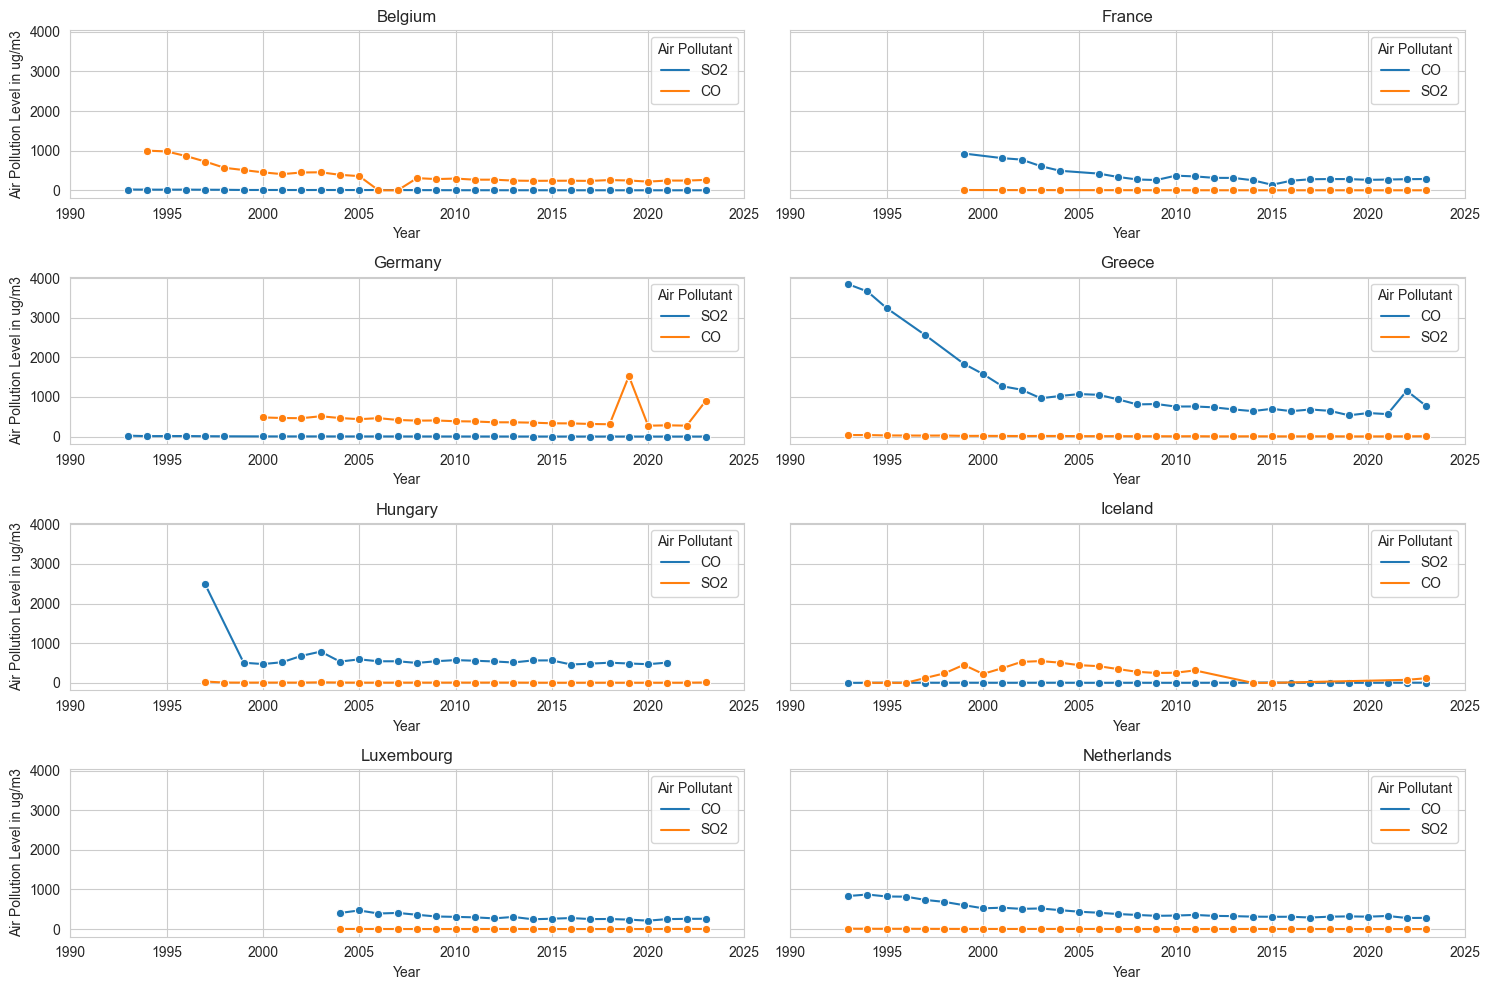

In [16]:
fig, ax = plt.subplots(4, 2, tight_layout=True, figsize=(15, 10), sharey=True)
pos_x, pos_y = 0, 0
for x in poll_df['Country'].unique():
    temp = poll_df.loc[poll_df['Country'] == x]
    sns.lineplot(temp, x='Year', y='Air Pollution Level', hue='Air Pollutant', ax=ax[pos_x, pos_y], marker='o')
    ax[pos_x, pos_y].set_xticks(np.arange(1990, 2030, 5))
    ax[pos_x, pos_y].set_title(x)
    ax[pos_x, pos_y].set_ylabel('Air Pollution Level in ug/m3')
    pos_y += 1
    if pos_y == 2:
        pos_x += 1
        pos_y = 0

plt.show()

This is hard to read, so we will make two plots, one for each pollutant.

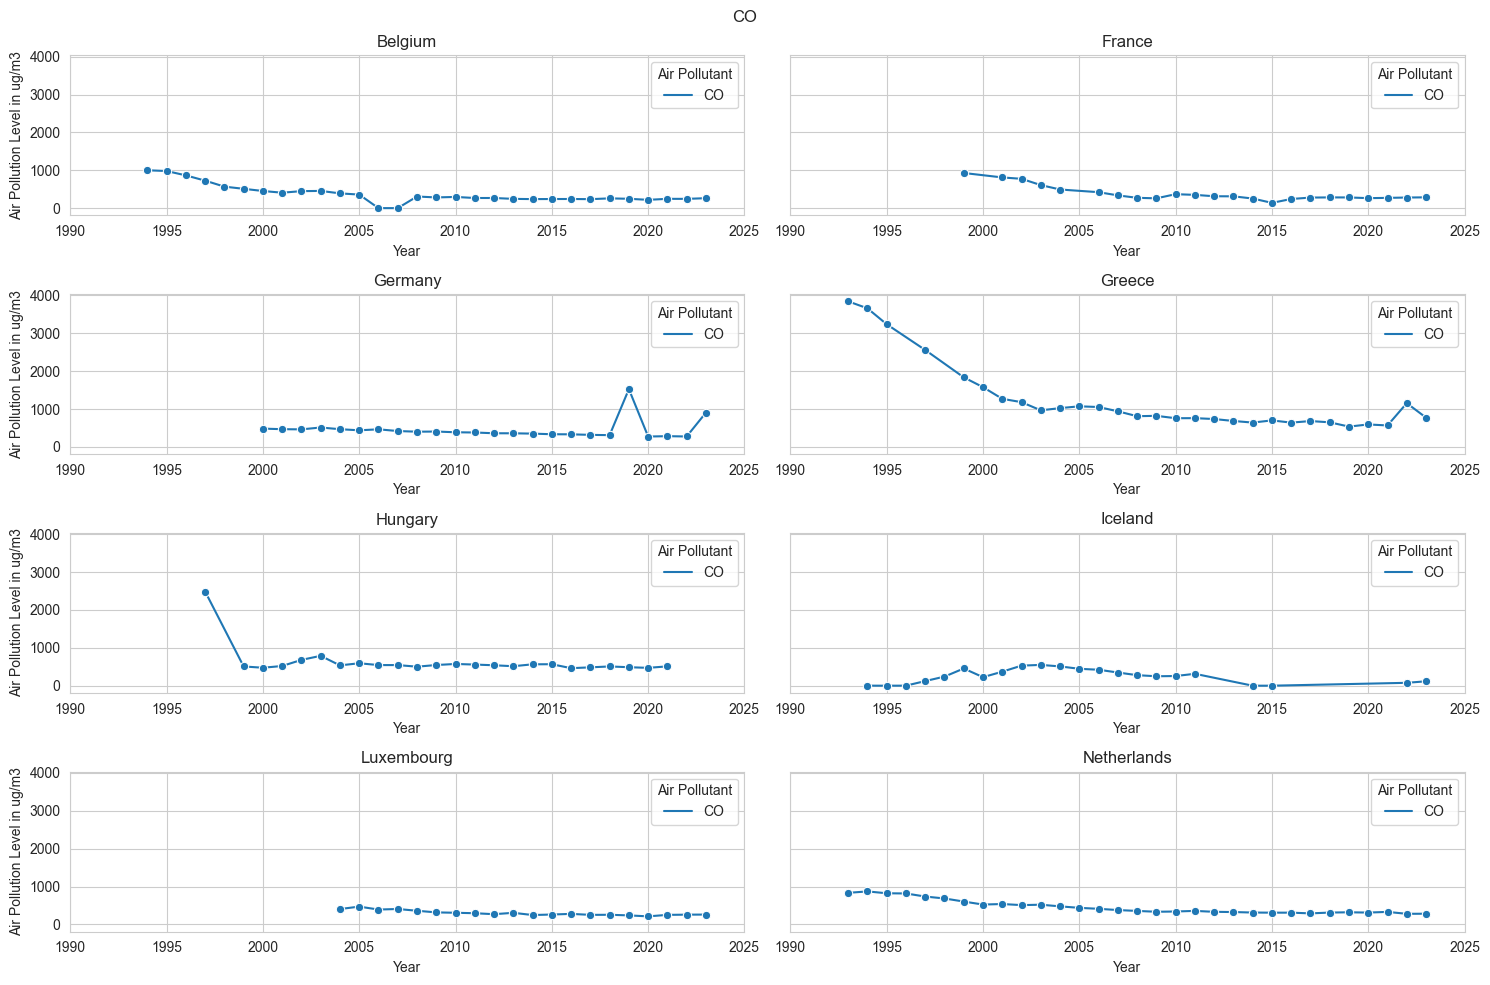

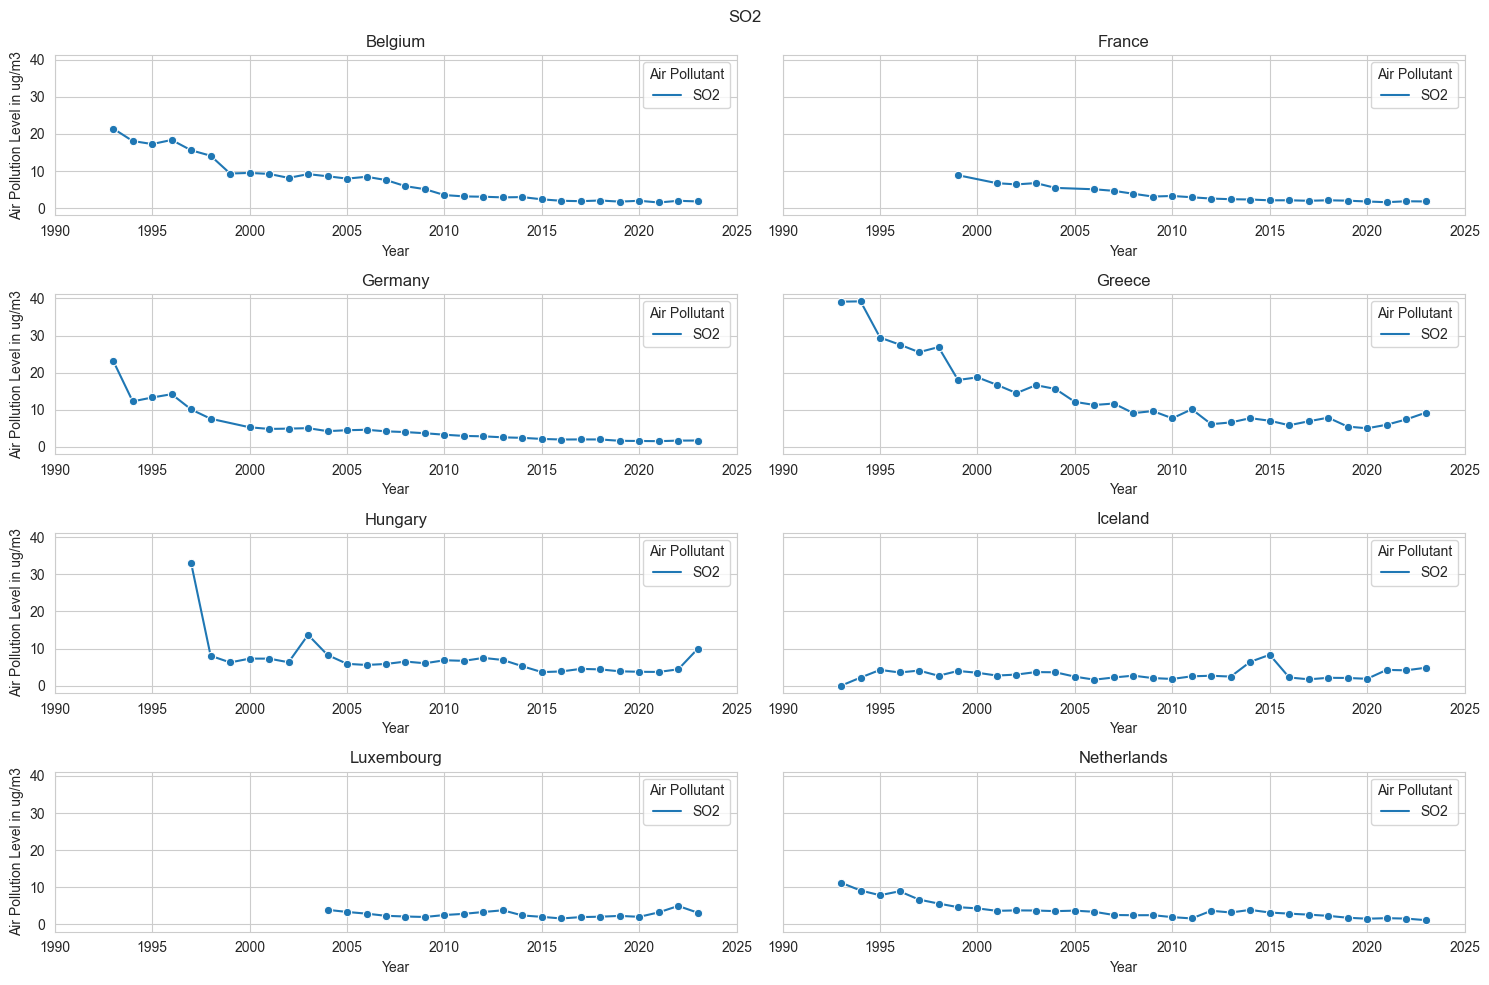

In [17]:
for p in pollutants:
    fig, ax = plt.subplots(4, 2, tight_layout=True, figsize=(15, 10), sharey=True)
    pos_x, pos_y = 0, 0
    for x in poll_df['Country'].unique():
        temp = poll_df.loc[(poll_df['Country'] == x) & (poll_df['Air Pollutant'] == p)]
        sns.lineplot(temp, x='Year', y='Air Pollution Level', hue='Air Pollutant', ax=ax[pos_x, pos_y], marker='o')
        ax[pos_x, pos_y].set_xticks(np.arange(1990, 2030, 5))
        ax[pos_x, pos_y].set_title(x)
        ax[pos_x, pos_y].set_ylabel('Air Pollution Level in ug/m3')
        pos_y += 1
        if pos_y == 2:
            pos_x += 1
            pos_y = 0

    plt.suptitle(p)
    plt.show()

We can notice that the pollution in the air stayed quite steady over the years in Europe. However, for some countries we can see a tendency of increasing quantity of SO2 in the atmosphere.

## Next, we will use this data to perform regression on it. Two models will be considered: simple linear regression and ARIMA. We will then evaluate which method is more likely to predict better results. This will help us determine whether further regulations should be added in the future.

The models will be defined as follows: they will be trained on data from 2010 through 2020 and tested on data from 2021 through 2023. This, for each country individually as trends are assumed to be country-specific. Then, using the fit model, we will make an approximation up to 5 years ahead for the quantity of each pollutant estimated to be observed in each country.

Let's define testing and training data

In [18]:
from sklearn.metrics import mean_squared_error, r2_score

def get_training_and_testing_data(data, pollutant, country):
    temp = data.loc[(data['Air Pollutant'] == pollutant) & (data['Country'] == country)]

    X_train = temp.loc[temp['Year'].isin(range(0, 2021)), 'Year'].values.reshape(-1, 1)
    y_train = temp.loc[temp['Year'].isin(range(0, 2021)), 'Air Pollution Level'].values.reshape(-1, 1)

    X_test = temp.loc[temp['Year'].isin(range(2021, 2024)), 'Year'].values.reshape(-1, 1)
    y_test = temp.loc[temp['Year'].isin(range(2021, 2024)), 'Air Pollution Level'].values.reshape(-1, 1)

    return X_train, y_train, X_test, y_test

def compute_errors(y_train, y_train_hat, y_test, y_pred):
    return [
        mean_squared_error(y_train, y_train_hat),
        r2_score(y_train, y_train_hat),
        mean_squared_error(y_test, y_pred),
        r2_score(y_test, y_pred)
    ]

### Linear Regression

Let's first determine the accuracy of the model for each country and pollutant.

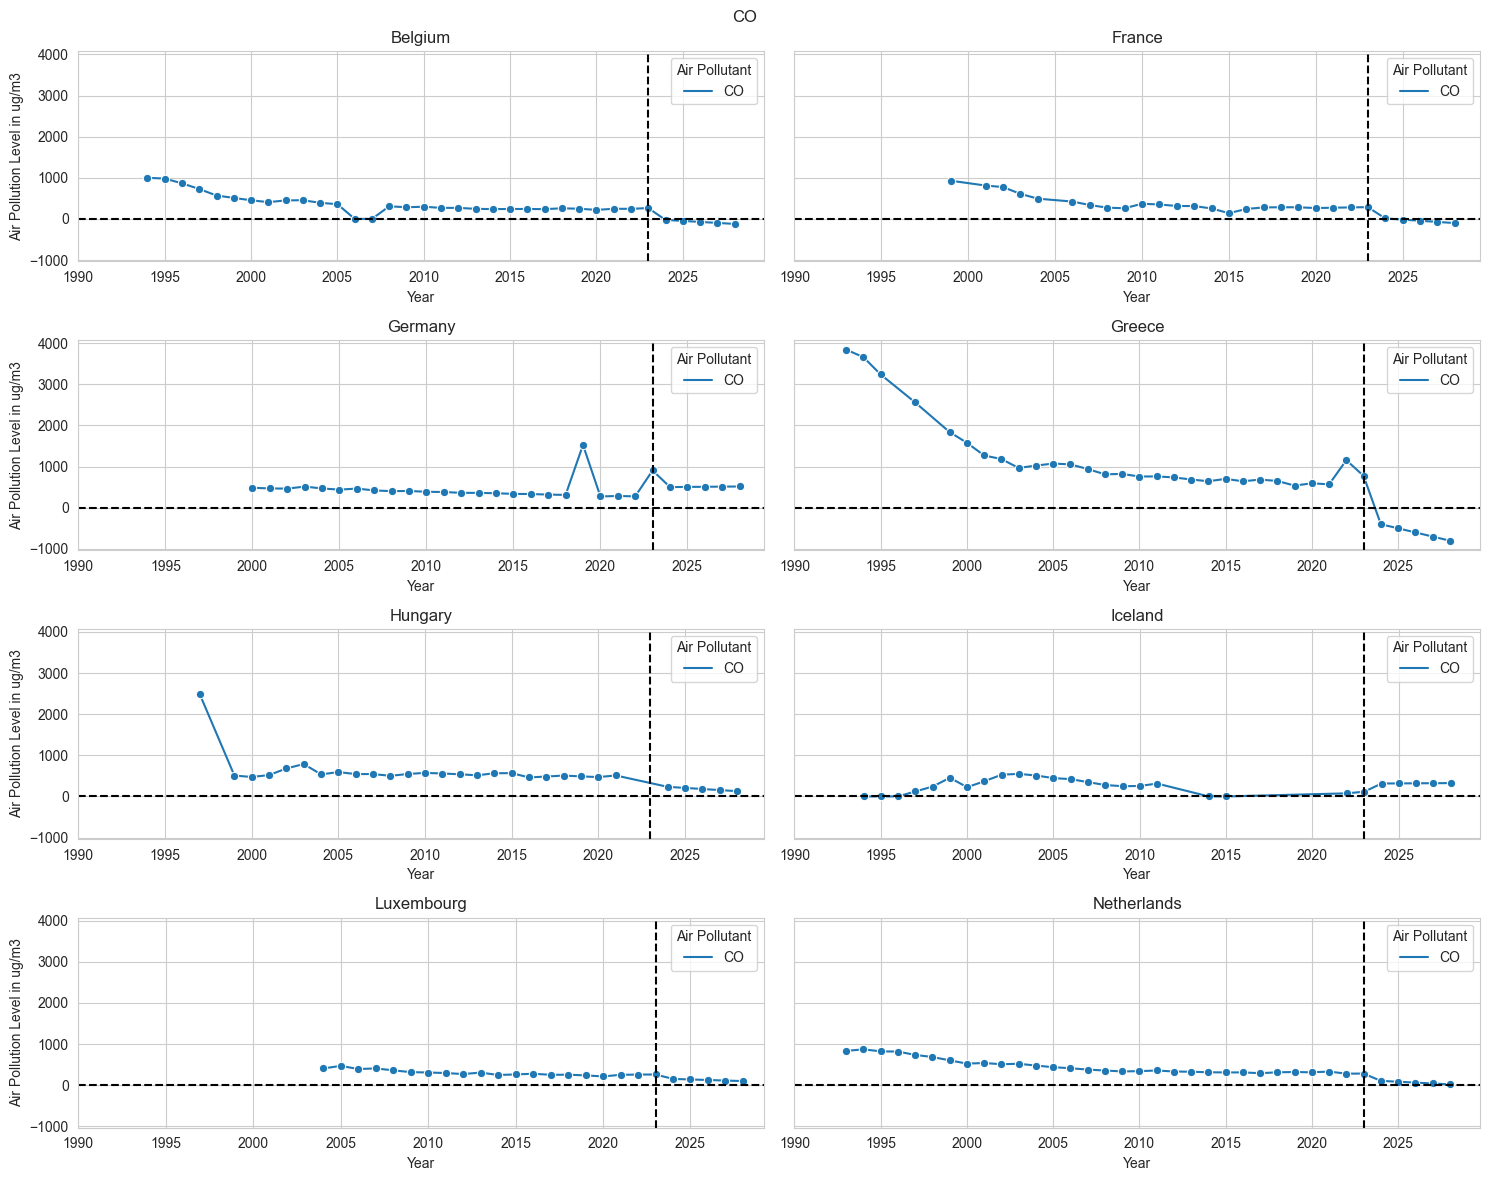

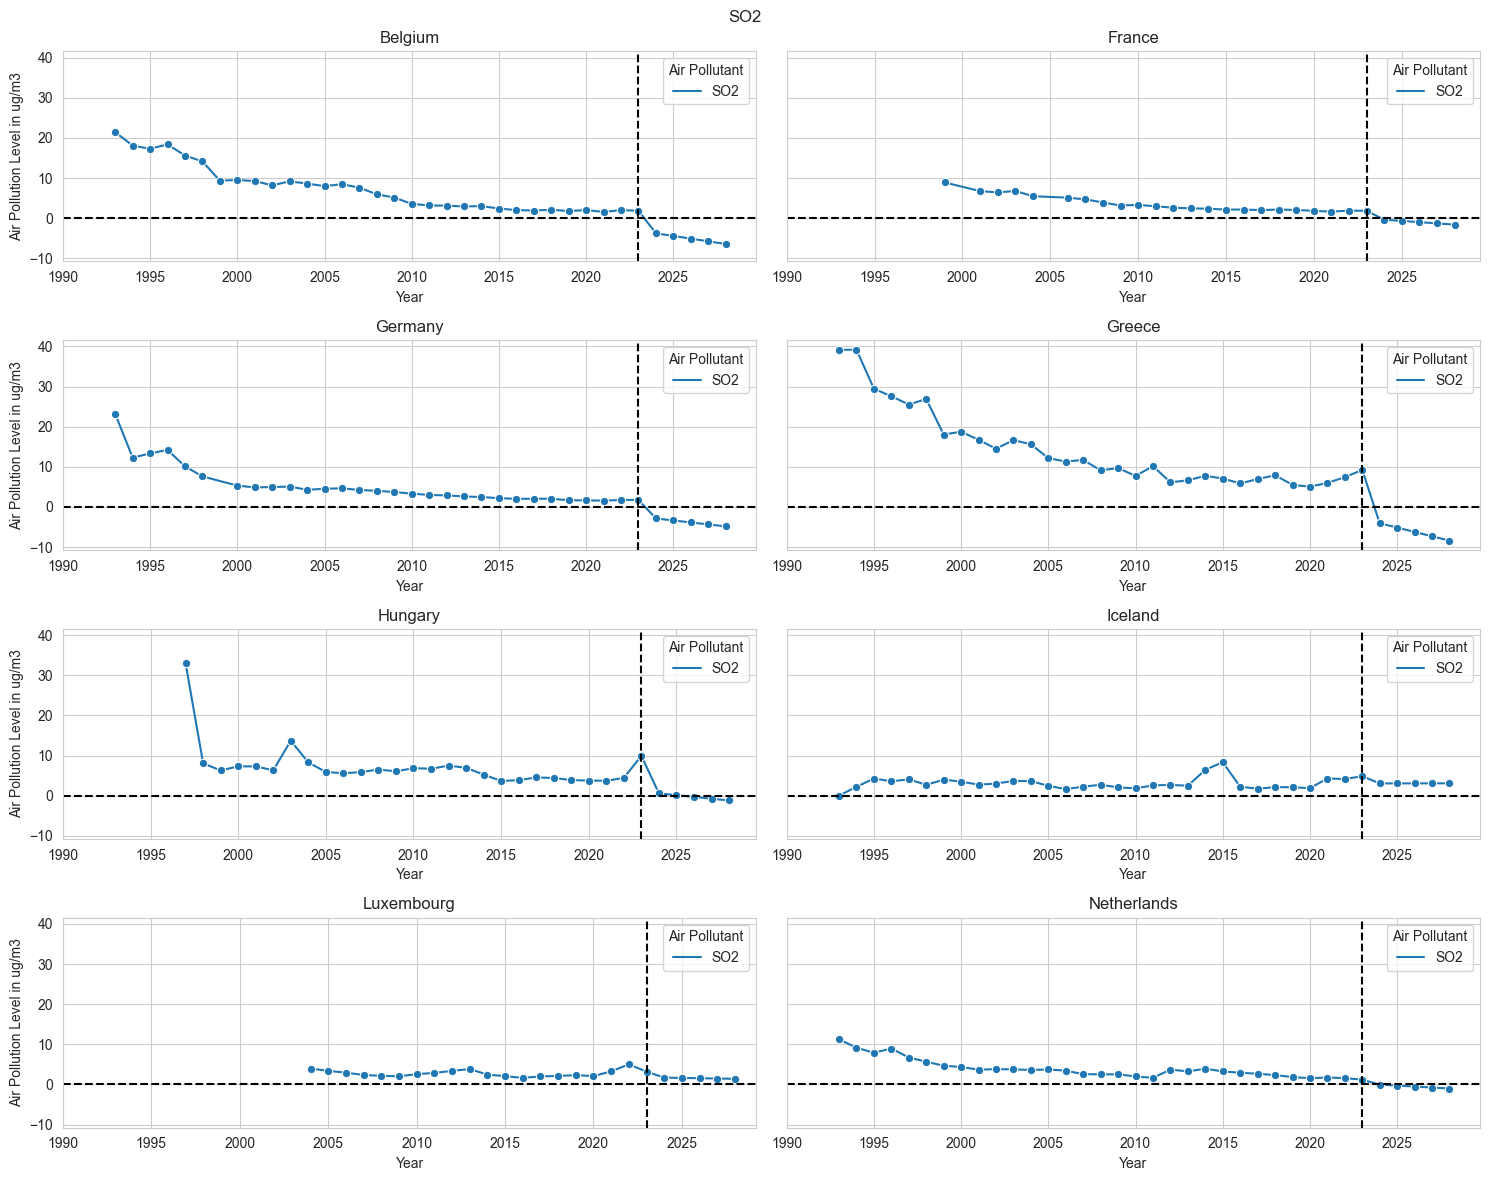

In [19]:
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")

model = LinearRegression()

forecast = poll_df.copy().reset_index(drop=True)
lg_errors = pd.DataFrame(
    columns=['Country', 'Air Pollutant', 'Training MSE', 'Training R^2', 'Testing MSE', 'Testing R^2']
)

for p in pollutants:
    fig, ax = plt.subplots(4, 2, tight_layout=True, figsize=(15, 12), sharey=True)
    pos_x, pos_y = 0, 0
    for x in poll_df['Country'].unique():
        X_train, y_train, X_test, y_test = get_training_and_testing_data(data=poll_df, pollutant=p, country=x)

        # Compute training and testing error of the model
        model_fit = model.fit(X_train, y_train)
        y_train_hat = model_fit.predict(X_train)
        y_pred = model_fit.predict(X_test)
        lg_errors.loc[len(lg_errors.index)] = [x, p] + compute_errors(y_train, y_train_hat, y_test, y_pred)

        # Forecast
        X_forecast = [[2024], [2025], [2026], [2027], [2028]]
        y_forecast = model_fit.predict(X_forecast)
        for i, y in enumerate(y_forecast):
            forecast.loc[len(forecast.index), :] = [x, X_forecast[i][0], p, y[0]]

        # Plot the forecast
        temp = forecast.loc[(forecast['Country'] == x) & (forecast['Air Pollutant'] == p)]
        sns.lineplot(temp, x='Year', y='Air Pollution Level', hue='Air Pollutant', ax=ax[pos_x, pos_y], marker='o')
        ax[pos_x, pos_y].axvline(x=2023, color='k', linestyle='--')
        ax[pos_x, pos_y].axhline(y=0, color='k', linestyle='--')
        ax[pos_x, pos_y].set_xticks(np.arange(1990, 2030, 5))
        ax[pos_x, pos_y].set_title(x)
        ax[pos_x, pos_y].set_ylabel('Air Pollution Level in ug/m3')
        pos_y += 1
        if pos_y == 2:
            pos_x += 1
            pos_y = 0

    plt.suptitle(p)
    plt.show()

lg_errors = lg_errors.groupby(['Country', 'Air Pollutant']).mean()
lg_errors.columns = pd.MultiIndex.from_arrays([['Training', 'Training', 'Testing', 'Testing'],
                                            ['MSE', 'R^2', 'MSE', 'R^2']])

### ARIMA

C:\Users\ovbcr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\ovbcr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\ovbcr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\ovbcr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\ovbcr\AppData\Local\Programs\Python

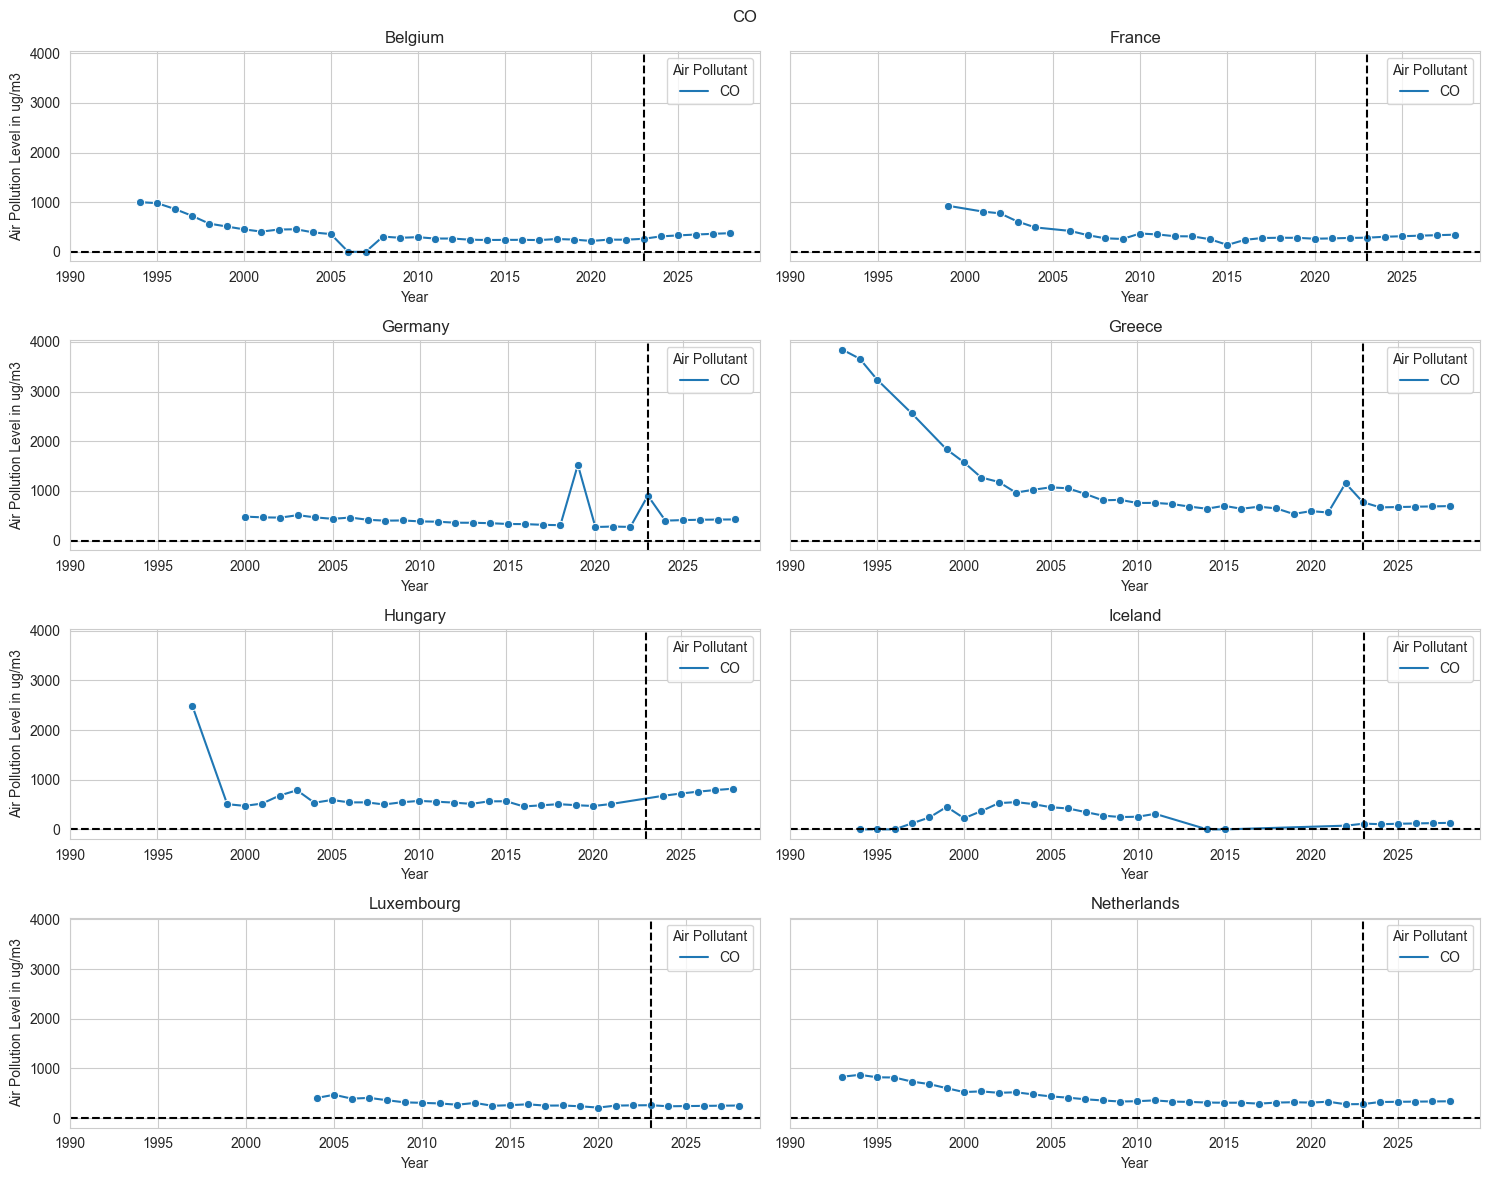

C:\Users\ovbcr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\ovbcr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\ovbcr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\ovbcr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\ovbcr\AppData\Local\Programs\Python

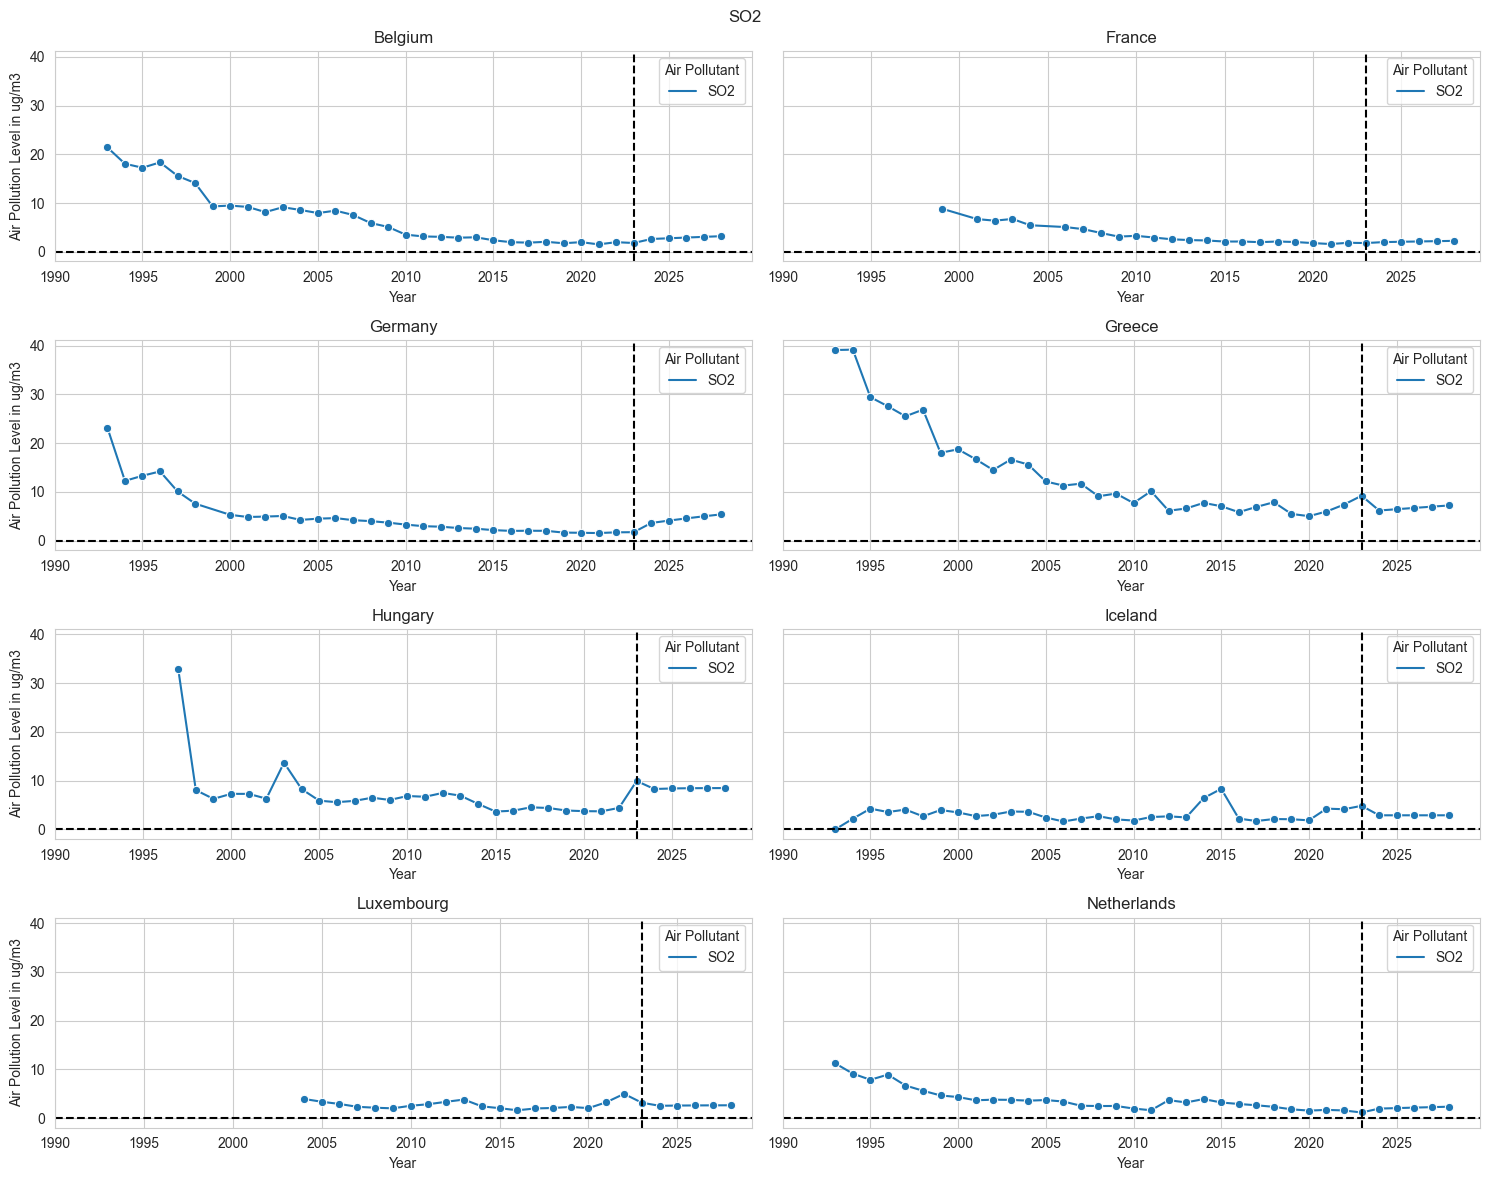

In [20]:
from statsmodels.tsa.arima.model import ARIMA

forecast = poll_df.copy().reset_index(drop=True)
arima_errors = pd.DataFrame(
    columns=['Country', 'Air Pollutant', 'Training MSE', 'Training R^2', 'Testing MSE', 'Testing R^2']
)

data = poll_df.set_index(['Country', 'Air Pollutant', 'Year'])
data.index = pd.MultiIndex.from_tuples(data.index, names=['Country', 'Air Pollutant', 'Year'])
data = data['Air Pollution Level']

# Convert data to time series object
data = data.unstack(['Country', 'Air Pollutant'])
data.index = pd.to_datetime(data.index.astype(str), format='%Y')

# Interpolate missing values
data = data.interpolate(method='from_derivatives')

# Define the training, testing and forecast ranges
train_end = pd.to_datetime('2020', format='%Y')
test_start = pd.to_datetime('2021', format='%Y')
test_end = pd.to_datetime('2023', format='%Y')
forecast_start = pd.to_datetime('2024', format='%Y')
forecast_end = pd.to_datetime('2028', format='%Y')

# Forecast for each country and air pollutant
for p in pollutants:
    fig, ax = plt.subplots(4, 2, tight_layout=True, figsize=(15, 12), sharey=True)
    pos_x, pos_y = 0, 0
    for x in data.columns.levels[0]:
        col = (x, p)
        X_train = data.loc[:train_end, col].dropna()
        X_test = data.loc[test_start:test_end, col].dropna()
        model = ARIMA(X_train, order=(1, 0, 1), freq='AS-JAN')

        # Compute training and testing error of the model
        model_fit = model.fit()
        y_train_hat = model_fit.predict(start=X_train.index.min(), end=X_train.index.max())
        y_test = model_fit.predict(start=X_test.index.min(), end=X_test.index.max())
        arima_errors.loc[len(arima_errors.index)] = [x, p] + compute_errors(
            X_train,
            y_train_hat.loc[X_train.index],
            X_test,
            y_test.loc[X_test.index],
        )

        # Forecast
        y_forecast = model_fit.predict(start=forecast_start, end=forecast_end)
        for i in y_forecast.index:
            if i.year > 2023:
                forecast.loc[len(forecast.index), :] = [col[0], i.year, col[1], y_forecast.loc[i]]

        # Plot the forecast
        temp = forecast.loc[(forecast['Country'] == x) & (forecast['Air Pollutant'] == p)]
        sns.lineplot(temp, x='Year', y='Air Pollution Level', hue='Air Pollutant', ax=ax[pos_x, pos_y], marker='o')
        ax[pos_x, pos_y].axvline(x=2023, color='k', linestyle='--')
        ax[pos_x, pos_y].axhline(y=0, color='k', linestyle='--')
        ax[pos_x, pos_y].set_xticks(np.arange(1990, 2030, 5))
        ax[pos_x, pos_y].set_title(x)
        ax[pos_x, pos_y].set_ylabel('Air Pollution Level in ug/m3')
        pos_y += 1
        if pos_y == 2:
            pos_x += 1
            pos_y = 0

    plt.suptitle(p)
    plt.show()

arima_errors = arima_errors.groupby(['Country', 'Air Pollutant']).mean()
arima_errors.columns = pd.MultiIndex.from_arrays([['Training', 'Training', 'Testing', 'Testing'],
                                               ['MSE', 'R^2', 'MSE', 'R^2']])

Let's compare the errors of both models.

In [21]:
print("Linear regression:")
print(lg_errors.to_string(float_format='%.2f'))

Linear regression:
                           Training         Testing         
                                MSE  R^2        MSE      R^2
Country     Air Pollutant                                   
Belgium     CO             25463.62 0.59   52237.09  -777.40
            SO2                3.83 0.88      18.33  -523.58
France      CO             13384.23 0.69   45510.04 -1362.19
            SO2                0.44 0.89       2.50  -204.51
Germany     CO             61335.11 0.01   85654.14     0.02
            SO2                7.87 0.67      12.98 -2100.69
Greece      CO            256742.28 0.71 1146896.72   -18.29
            SO2               17.24 0.82      93.87   -52.38
Hungary     CO            130908.40 0.19   39317.36      NaN
            SO2               23.26 0.29      30.71    -2.97
Iceland     CO             34607.01 0.01   46711.49  -115.78
            SO2                2.35 0.00       1.99   -20.69
Luxembourg  CO               758.07 0.85    6281.44  -574.89
     

In [22]:
print("ARIMA:")
print(arima_errors.to_string(float_format='%.2f'))

ARIMA:
                           Training        Testing        
                                MSE   R^2      MSE     R^2
Country     Air Pollutant                                 
Belgium     CO             19732.48  0.68   393.83   -4.87
            SO2                5.65  0.83     0.33   -8.41
France      CO             10726.10  0.78    22.43    0.33
            SO2                0.86  0.81     0.02   -0.48
Germany     CO             51740.27  0.16 92961.59   -0.07
            SO2               11.05  0.52     0.94 -151.71
Greece      CO            238996.54  0.75 89350.19   -0.50
            SO2               21.15  0.78     4.81   -1.74
Hungary     CO            151554.82  0.18   487.92     NaN
            SO2               39.52 -0.21     5.65    0.27
Iceland     CO              8732.94  0.75   169.00    0.65
            SO2                1.79  0.24     3.12  -32.96
Luxembourg  CO              1700.59  0.66   719.92  -65.00
            SO2                0.28  0.38     2.8

Looking at the errors, we can see that both models achieve similar training errors. However, we can see that the `ARIMA` model is much more accurate on testing data than the `linear regression`. Moreover, looking at the plots, the `linear regression` model does not make sense as it outputs negative values, which can not be real.

Notice that the `R^2` metric for Hungary, CO is `NaN`. This is because we only have one data point available for the testing data.

Hence, we conclude that the `ARIMA` model is a model that can predict decently future pollution levels. Thanks to this, one would be able to estimate when new regulations should be added.

### ETHICAL CONSIDERATIONS

The data itself was measured as most air quality is measured, with sensors on high up locations like traffic poles, and using satellite heat imagery. Given that this data is not personal to anyone, and the measurements are never precise enough to violate someone's privacy, there are essentially no ethical considerations for the data collection.

How we obtained this data however, could be the cause for ethical consideration. When trying to download the data, we encountered a setback where it turns out we can only download data in increments of 100000 rows out of 1500000, this would've taken a lot of time to compile, so instead we automated the process using webscraping. Webscraping is usually not allowed for most websites due to the prevalence of bots, however, we did not see any website specific rulings on the dis-allowance of webscraping. Plus, the only reason we used webscraping is to shorten the length of menial labour, so we may spend more time on actual Data Analysis.


To Conclude we did use webscraping to collect data slightly faster than manually downloading the data in increments, but this has minor ramifications.